In [2]:
import itertools
import math
from matplotlib import pyplot as plt
import numpy as np
import random

# Physical constants for experiment

In [9]:
ev_c2 = 1.783e-36   # eV/c^2 in units [kg]
me_kg   = 9.1e-31   # mass of e- [kg]
me = me_kg/ev_c2    # mass of e- [eV/c^2]
c = 3e8             # speed of light [m/s]

v = np.sqrt(1-(510/(60+510))**2) # gamma factor
# v vs. non-relativistic calculation for velocity
print('(non)relativistic electron velocity(/c) is ' + str(v) + ' (' + str(np.sqrt(2*60/510)) + ')')      

h = 4.135e-15         # plank's constant [eV]  (not h-bar, just h)
l_NV = 575            # nv wavelength [nm]
f_NV = c * 1e9/l_NV   # frequency (conversion nm <--> m)
E_NV = h * f_NV       # energy [eV]
E_660 = h * (c*1e9/660)
E_610 = h * (c*1e9/610)
DE = E_NV - E_660     # energy lost to plasmon [eV]
print('energy lost to plasmon around ' + str(DE) + ' eV')


q = 1.602e-19         # charge of electron  [C]
I0 = q / 1e-9 * 1e9   # nano-coulumb/second [nA]
print('current for 1e- per nanosecond:' + str(I0) + ' nA')
print('mean times are :',[.1602/I_nA for I_nA in np.linspace(.100, 1.1,6)])


(non)relativistic electron velocity(/c) is 0.446593756539 (0.485071250073)
energy lost to plasmon around 0.27784584980237126 eV
current for 1e- per nanosecond:0.1602 nA
mean times are : [1.6020000000000001, 0.53399999999999992, 0.32040000000000002, 0.22885714285714284, 0.17800000000000002, 0.14563636363636362]


# Monte Carlo Simulation Cathodoluminescence 
Following Meuret, Kociak, et. al., PRL & supplemental material. 


We outline the experimental and some material parameters taken from the literature which are allow our caculations to be realistic with respect to materials properties. 

#### Energy-scales
The electrons are accelerated with $60 keV$ potential. At this energy scale the electrons move at a veloctity $v = .44 * c$ 

1. Plasmon modes should be $\mathcal{O}(10 eV)$ excitations. This correlates well with the big EELS peak around 40 eV in Kociak's supplemental material. 
2. Electron-hole exicton pairs are of $E_{eh} = 5 eV$ as per the band-gap in diamond
3. NV$^0$ centers with $2.156 eV$ (575nm) energy gap between a doublet $^2E$ states and $^2A$ states. The NV gap isembedded within the semiconductor band-gap. 
4. There exist phonon bands with much lower energies than all the modes listed above. Photons exhibiting maximal bunching lie between 610-665 nm and this corresponds to a loss of $\sim .25eV$



#### Timescales

The e-beam current depends on the extraction voltage which removes electrons.In the Kociak paper the currents range between $1pA$-$100pA$ while the ORNL experiment uses currents betwee $100 pA$ to $10 nA$. 

0. Bunching bandwidth of $\sim 100ns$ for 610 nm and 665 nm filtered data.
1. NV decay timescales seems to be on the order of $\mathcal{O}(10ns)$. 


#### Other physical constraints 

0. Following Kociak in the supplemental material section 6 the average plasmon creation number should be taken around ~2 
1. The interaction probability is defined as $P_{INT} \equiv 1 - \exp \left\{ - l_d \sigma \rho \right\}$]
   * The NV density is ~ 1200 NV color centers / nanocrystal. Since each nanocrystal is ~ $100 nm^3$ that comes to a rough density of $\rho = 1.2 *10^{-3} \frac{NV}{nm^3}$ or $\approx 1 \frac{NV}{(10nm)^3}$


## Time series simulation 
The time series simulation is performed in two different ways below 

1. We discretizing time into timesteps dt and at each either select an electron arrival or do not. 
   * Likewise, for NV's which are excited, they are allowed to probablistically decay at each timestep.. 
    
B. Following Kociak again, we stochastically pick electron arrivals times. 
   * These arrival time shall be the excitation times for the (possibly many) NV's which are stimulated within a very short (ps) time window. 
   * We also stochastically choose NV radiation times 


# Poissonian time series simulation

We simulate the experimenal data using a simple monte carlo simulation. 
In our numerics we build a probability function $t_{em}$ as matrix consiting of radiation times.
The radiation times are taken to depend on the electron beam current and on the nano-crystal-NV physics. 

$$ t^{ij}_{em} $$

1. Given a constant current, the average arrival time $\Delta t$ between electrons in the e-beam is $\Delta t = I/q_e$ where $I$ is the beam current and $q_e = 1.602*10^{-19}C$ is the electron charge. Generating the inter-electron times $\Delta i$'s from a Poissonian distribution is performed by the emn_arrivals function. Define the global arrival times recursively $t_n = \Delta_n + t_{n-1}$ to consider the set $\{ t_1, ... t_N\}$. $$ $$ The $\Delta i$'s are sampled as follows. Conider the poisson probabilty distibution $P(k,\lambda) = {\displaystyle {\frac {\lambda ^{k}e^{-\lambda }}{k!}}}$. The probablity of for the $k=0$ event for $m$ consecutive samples is $P(0,\lambda)^m = e^{-m \lambda}$. This exponential decay distribution and electron times are thus simulated by taking $\Delta_i = - t_m \ln(1-r_i)$ where each $r_i$ is a random number evenly distributed along the interval $\left[0,1\right]$. This collection of $\{ \Delta_i \}$ and the interaction times ($\{ t_1, ... t_N\}$) constitute the first poissonian simulated data.


2. At each $t_i$ the electron activates a number of microscipic modes  associated with the Nano-diamond samples. Since we count the emissions originating from the NV color centers, we construct an simple effective model to treat the internal dynamics. Due to the broad nature of the electron beam exictations, many modes (plasmons, phonons, e-h excitions, and NVs) are excited at each electron arrival time $t_i$. A simple model considering the activation of NV's through plasmonic, and exiton pathways was considered earlier \cite{Meuret}. 


 At each of these times  are excited. Eventually the excited NV's radiate at some later time. The radiation times are output by the radiation times function
 generates a series of times at from which NV centers may emit


3. Finally we post-proccess the radiation times into a histogram style g2 correlation function

In [7]:
def em_arrrivals(t_m, number = 1000):
    """
    Simulate the arrival times of e-'s arriving
    according to a poission distribution given 
    
    Parameters
    ----------
    t_m: mean arrival time (lambda parameter)
    number: number of samples
    
    Retruns
    -------
    delta_ts: delays between electrons
    times:    times of electron arrivals
    """
    delta_ts = [- 1/t_m * np.log(1-random.random()) for i in range(number)]
    times = [0] * number
#     times[0] = delta_ts[0] # remove if condition with this boundary case
                             # loop over delta_ts[1::]
    for i,t in enumerate(delta_ts):
        if i == 0:
            times[i] = delta_ts[i]
        else:
            times[i] = times[i-1] + delta_ts[i]
    return delta_ts, times

def radiation_times(times, N_NV, t_r,
                    alpha = [1], t_PLs = [1],
                    poisson = True):
    """
    Simulate the radaition times of an unbounded collection of NV's
    
    Parameters
    ----------
    times: discretized times at which NV's may be excited
    N_NV : average number of NV's excited per e-
    t_r  : mean NV relaxation/radiation timescale
    alpha: list assigning a probability to the ZPL and other phonon lines
           must be normalized!
    t_PLs: fractions of ZPL radiation lifetimes assigned to vibronic modes
           should be the same length as alpha

    Returns
    -------
    rad_times: sorted list of times at which a radiation event occurs
    
    """                
    if poisson:
        nv_arrivals = np.random.poisson(N_NV, len(times)) 
    else:
        nv_arrivals = np.array([int(N_NV)] * len(times))
        
    alpha_c = np.cumsum(alpha)       # cumulative sum of alpha   
    rad_times = []                   # simulate the radiation times series data
    for k in range(len(times)):
        for j in range(nv_arrivals[k]):
            r = random.random()
            for i in range(len(alpha_c)):
                if r < alpha_c[i]:
                    rad_times.append(times[k] - t_r * t_PLs[i] * 
                                     np.log(1-random.random()))
                    break                    
    rad_times.sort()
    return  rad_times

def delays(rad_times, tau_max):
    """
    Calculate delays 'between each photon and all the others' 
    within a time window of width tau_max. This way we may
    reconstruct the g2 correlation function
    in the "histogram mode" used to experimentally determine $g^{(2)}$. 
    The histogramming corresponds to the convolution of 
    two functions in some discrete time specificed by the bin width

    Parameters
    ----------
    rad_times: a list of ordered radiation times 
    tau_max: time window, e.g. of 100 ns, for duration of coincedence counting
    
    Returns:
    --------
    delay times: w/o self delay at \tau = 0.0
    """
    t_s = [t for t in rad_times if t > min(rad_times) + tau_max and t < max(rad_times) - tau_max ]

    delay_times = []
    for t1 in t_s:
        
        i = rad_times.index(t1)
        j = i + 1
        k = i - 1
        
        while abs(rad_times[j] - t1) < tau_max:
            delay_times.append(rad_times[j]-t1)
            j += 1

        while abs(rad_times[k] - t1) < tau_max:
            delay_times.append(rad_times[k]-t1)
            k -= 1
            
    return  delay_times

### Single data point for the triple Monte Carlo poissonian chain of events 


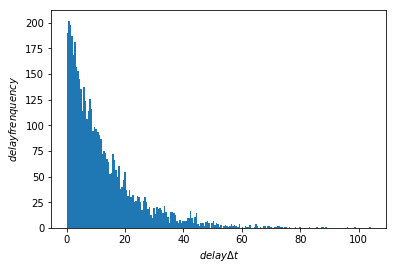

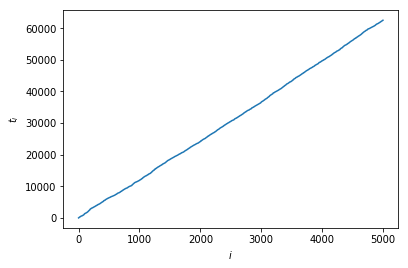

Number of NV emissions:9998


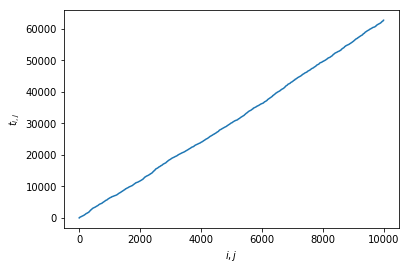

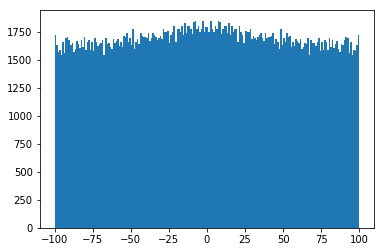

In [8]:
# Physical scales #
tm = .080         # electron mean arrival time [ns] -----    # Single mean 
N_NV = 2          # ratio of NV's to e-'s 
t_r = 50          # NV radiation timescale [ns]    --------  # varying radiation time

# histogram binning arguments 
tau_max = 100
n_bins = 200

# test numpy poissonian sampling
# plt.hist(np.random.poisson(0.5, 100000), n_bins)
# plt.show()

arrival_times = em_arrrivals(tm , number=int(5e3))

plt.hist(arrival_times[0], n_bins)
plt.xlabel('$delay \Delta t$')
plt.ylabel('$delay frenquency$')

plt.show()
plt.plot(arrival_times[1])
plt.xlabel('$i $')
plt.ylabel('$t_i $')
plt.show()

# r_tms = radiation_times(arrival_times[1], N_NV, t_r,   alpha = [1], t_PLs = [1])

alphas = [[1,0,0,0], [.7,.2,.1,0], [.2,.4,.3,.1], [0,.2,.5,.3]]
# relax_ratios = [1,.5,.25,.1]
r_tms = radiation_times(arrival_times[1], N_NV, t_r,
                        alpha = alphas[0], t_PLs = [1,.5,.25,.1])
print('Number of NV emissions:' + str(len(r_tms)))
plt.plot(r_tms)
plt.xlabel('$i,j $')
plt.ylabel('$t_{i,j} $')
plt.show()

plt.hist(delays(r_tms, tau_max), n_bins)
plt.show()

# Dependence of the signal on the number of electron arrivals.

The total number of time series events is ~ $N_s * N_{NV}$

In [15]:
num = 90
freq_dist = np.linspace(1,.5,90)**1
freq_dist = list(np.array(freq_dist)/sum(freq_dist))
tmscales = np.linspace(4,.001,num)

# Ns  = [5e2, 1e3, 5e3, 1e4, 5e4]
# Ns = [int(n) for n in Ns]
Ns = [int(n) for n in np.linspace(5e2, 3e4, 5)]
# f, ax = plt.subplots(1, sharex=True)
data = []
for N in Ns:
    rt = radiation_times(em_arrrivals(1.602*10/.192, N)[1],
                         N_NV,
                         t_r,
                         freq_dist, #[.25,.25,.25,.25],
                         tmscales)  #[1.25,.25,.1,.01])
    d = delays(rt, tau_max)

#     at = em_arrrivals(tm, N)[1] # arrival times
#     rt = radiation_times(at, N_NV, t_r)

    # look through delays at different currents 

    hist, bin_edges = np.histogram(d, bins=n_bins)           # Generate the histogram data directly
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.      # Get the centres rather than the edges
    hists = hist/((np.mean(hist[int(3*n_bins/4):]) +
                  np.mean(hist[:int(1*n_bins/4)]))/2)        # Normalize histogram counts
    bins = bin_centers                                       # Plot with [ns] time units
    
    print('number of samples taken: ', N)
#     plt.plot(bins, hists, label = str(N))
    
    data.append((bins, hists))

f, ax = plt.subplots(2, sharex=False, figsize = (8,12))
for i, d in enumerate(data):
    ax[0].plot(d[0], d[1],)
ax[0].set_xlabel('$\\tau (ns)$')
ax[0].set_ylabel('$g^{(2)}(\\tau)$')
# ax[0].legend(['$N_{NV}$ = ' + str(N_NV) for N_NV in N_NV_range])

ax[1].plot(NS, [data[i][1][n_bins//2] for i in range(len(Ns))] , '.-')
ax[1].set_ylim(0,)
ax[1].set_xlabel('N_{samples}$')
ax[1].set_ylabel('g^{(2)}(0)')
plt.show()


number of samples taken:  500
number of samples taken:  7875
number of samples taken:  15250
number of samples taken:  22625
number of samples taken:  30000


NameError: name 'N_NV_range' is not defined

# dependence on number of NVs

We see that the $g^{(2)}$ correlation function appears to be independent of the NV/e- ratio $N_{NV} \geq 1$ parameter.  

2.0 is done
5.6 is done
9.2 is done
12.8 is done
16.4 is done
20.0 is done


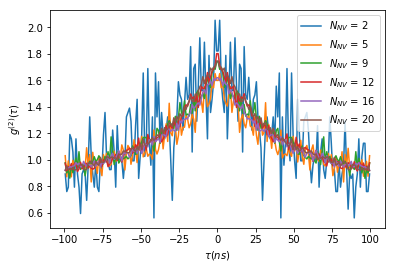

In [9]:
N_NV_range = np.linspace(2,20,6)
f, ax = plt.subplots(1, sharex=True)
for N_NV in N_NV_range:
    at = em_arrrivals(tm, number=500)[1] # arrival times
    rt = radiation_times(at, N_NV, t_r)
    d = delays(rt, tau_max)

    # look through delays at different currents 

    hist, bin_edges = np.histogram(d, bins=n_bins)           # Generate the histogram data directly
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.      # Get the centres rather than the edges
    hists = hist/((np.mean(hist[int(3*n_bins/4):]) +
                  np.mean(hist[:int(1*n_bins/4)]))/2)        # Normalize histogram counts
    bins = bin_centers                                       # Plot with [ns] time units
    print(str(N_NV) + ' is done')                            # simulation length increases with N_NV
    plt.plot(bins, hists, label = '$N_{NV}$ = ' + str(int(N_NV)))
    
plt.xlabel('$\\tau (ns)$')
plt.ylabel('$g^{(2)}(\\tau)$')
plt.legend()
plt.show()

NVs excited per electron: 2.0
NVs excited per electron: 6.4
NVs excited per electron: 10.8
NVs excited per electron: 15.2
NVs excited per electron: 19.6
NVs excited per electron: 24.0


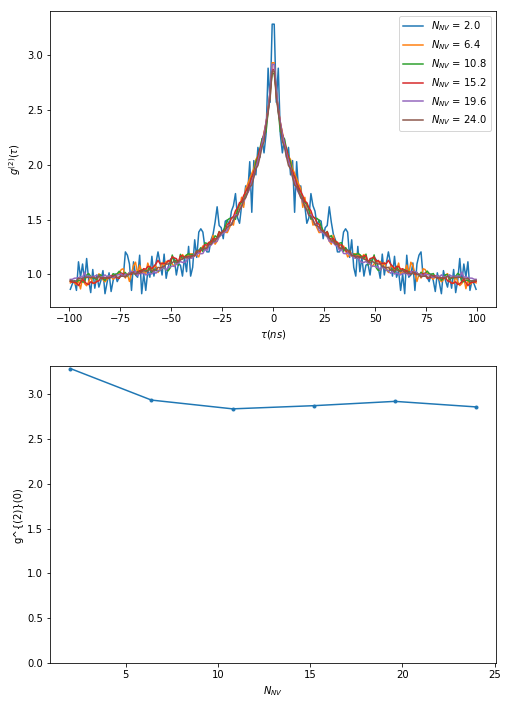

NVs excited per electron: 2.0
NVs excited per electron: 6.4
NVs excited per electron: 10.8
NVs excited per electron: 15.2
NVs excited per electron: 19.6
NVs excited per electron: 24.0


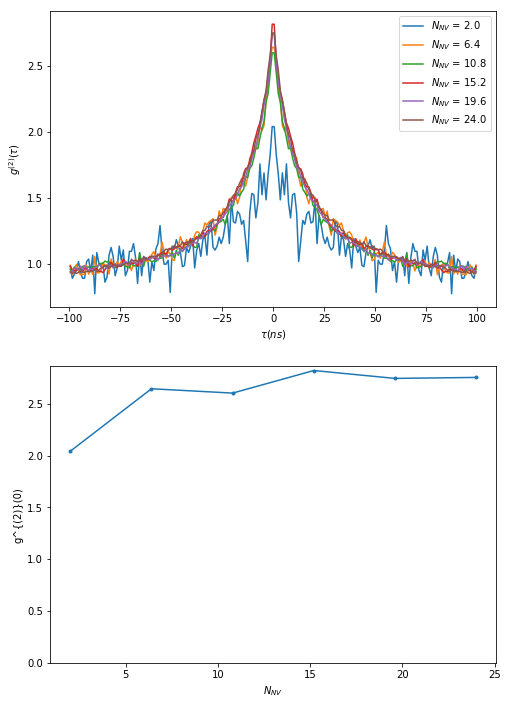

In [48]:
N = 2000

num = 90
freq_dist = np.linspace(1,.5,90)**1
freq_dist = list(np.array(freq_dist)/sum(freq_dist))
tmscales = np.linspace(4,.001,num)

N_NV_range = np.linspace(2,24,6)
data = []
for N_NV in N_NV_range:
    print('NVs excited per electron:' , N_NV)
    rt = radiation_times(em_arrrivals(1.602*10/.192, N)[1],
                         N_NV,
                         t_r,
                         freq_dist, #[.25,.25,.25,.25],
                         tmscales)  #[1.25,.25,.1,.01])
    d = delays(rt, tau_max)

    hist, bin_edges = np.histogram(d, bins=n_bins)           # Generate the histogram data directly
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.      # Get the centres rather than the edges
    hists = hist/((np.mean(hist[int(3*n_bins/4):]) +
                  np.mean(hist[:int(1*n_bins/4)]))/2)        # Normalize histogram counts
    bins = bin_centers                                       # Plot with [ns] time units
    data.append((bins, hists))

f, ax = plt.subplots(2, sharex=False, figsize = (8,12))
for i, d in enumerate(data):
    ax[0].plot(d[0], d[1],)
ax[0].set_xlabel('$\\tau (ns)$')
ax[0].set_ylabel('$g^{(2)}(\\tau)$')
ax[0].legend(['$N_{NV}$ = ' + str(N_NV) for N_NV in N_NV_range])

ax[1].plot(N_NV_range, [data[i][1][n_bins//2] for i in range(len(N_NV_range))] , '.-')
ax[1].set_ylim(0,)
ax[1].set_xlabel('$N_{NV}$')
ax[1].set_ylabel('g^{(2)}(0)')
plt.show()


# do not sample from poisson, constant N_NV
data = []
for N_NV in N_NV_range:
    print('NVs excited per electron:' , N_NV)
    rt = radiation_times(em_arrrivals(1.602*10/.192, N)[1],
                         N_NV,
                         t_r,
                         freq_dist, #[.25,.25,.25,.25],
                         tmscales,  #[1.25,.25,.1,.01]
                         poisson = False)  
    d = delays(rt, tau_max)

    hist, bin_edges = np.histogram(d, bins=n_bins)           # Generate the histogram data directly
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.      # Get the centres rather than the edges
    hists = hist/((np.mean(hist[int(3*n_bins/4):]) +
                  np.mean(hist[:int(1*n_bins/4)]))/2)        # Normalize histogram counts
    bins = bin_centers                                       # Plot with [ns] time units
    data.append((bins, hists))

f, ax = plt.subplots(2, sharex=False, figsize = (8,12))
for i, d in enumerate(data):
    ax[0].plot(d[0], d[1],)
ax[0].set_xlabel('$\\tau (ns)$')
ax[0].set_ylabel('$g^{(2)}(\\tau)$')
ax[0].legend(['$N_{NV}$ = ' + str(N_NV) for N_NV in N_NV_range])

ax[1].plot(N_NV_range, [data[i][1][n_bins//2] for i in range(len(N_NV_range))] , '.-')
ax[1].set_ylim(0,)
ax[1].set_xlabel('$N_{NV}$')
ax[1].set_ylabel('g^{(2)}(0)')
plt.show()



### Current dependence

Here we take mean arrival times which correspond to the experimental beam currents. 
Let us start off by modeling the Kociak data ('at low temperature'). Here we dont include any information about the phonon modes, focusing on the $g^2$ due to the ZPL. The point is that the signal rapidly disappears as the current increases. 

Also, note that the FWHM seems to have some small (i.e. staying within the same order of magnitude) dependence on the current. I believe this is consistent with the experimental data. 

#### Monotone emissons

mean arrival time [ns] :  834.375
current [nA] :  0.000192
mean arrival time [ns] :  489.9082568807339
current [nA] :  0.00032700000000000003
mean arrival time [ns] :  324.2914979757085
current [nA] :  0.000494
mean arrival time [ns] :  227.55681818181822
current [nA] :  0.000704
mean arrival time [ns] :  179.79797979797982
current [nA] :  0.000891
mean arrival time [ns] :  142.02127659574472
current [nA] :  0.0011279999999999999


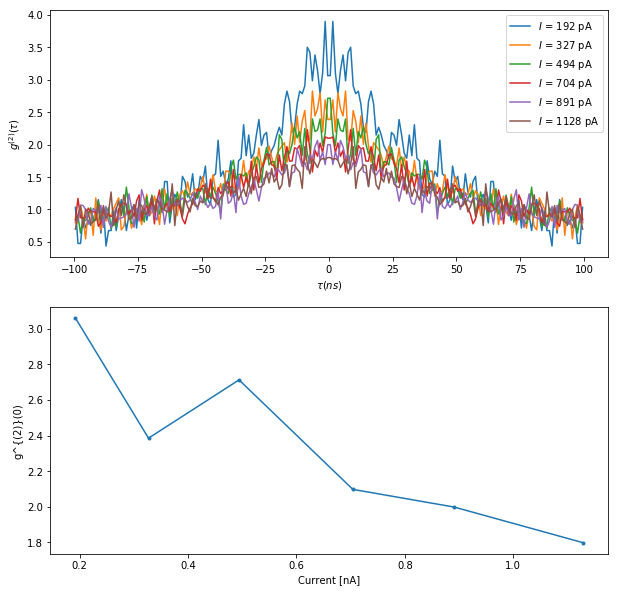

In [18]:
# currents = np.linspace(.192, 1.128,6)
currents = [.192, .327, .494, .704, .891, 1.128]
mean_times = [1.602/(.01*I_nA) for I_nA in currents]

data = []
for tm in mean_times:
    print('mean arrival time [ns] : ', tm)
    print('current [nA] : ',1.602/(10*tm))
    at = em_arrrivals(tm, 2000)            # Generate arrival times (at)
    rt = radiation_times(at[1], N_NV, 50)
    d = delays(rt, tau_max)

    # look through delays at different currents 

    hist, bin_edges = np.histogram(d, bins=n_bins)           # Generate the histogram data directly
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.      # Get the centres rather than the edges
    hists = hist/((np.mean(hist[int(3*n_bins/4):]) +
                  np.mean(hist[:int(1*n_bins/4)]))/2)        # Normalize histogram counts
    bins = bin_centers                                       # Plot with [ns] time units
    data.append((bins, hists))

f, ax = plt.subplots(2, sharex=False, figsize = (10,10))
for i, d in enumerate(data):
    ax[0].plot(d[0], d[1],)
ax[0].set_xlabel('$\\tau (ns)$')
ax[0].set_ylabel('$g^{(2)}(\\tau)$')
ax[0].legend(['$I$ = ' + str(int(c*1000)) + ' pA' for c in currents])

ax[1].plot(currents, [data[i][1][n_bins//2] for i in range(len(currents))] , '.-')
ax[1].set_xlabel('Current [nA]')
ax[1].set_ylabel('g^{(2)}(0)')
# ax[1].legend()
plt.show()

#### Multispectral emissons

mean arrival time [ns]: 0.8343750000000001
current [nA]:  19.199999999999996
mean arrival time [ns]: 0.48990825688073397
current [nA]:  32.699999999999996
mean arrival time [ns]: 0.32429149797570855
current [nA]:  49.39999999999999
mean arrival time [ns]: 0.22755681818181822
current [nA]:  70.39999999999999
mean arrival time [ns]: 0.17979797979797982
current [nA]:  89.1
mean arrival time [ns]: 0.1420212765957447
current [nA]:  112.79999999999998


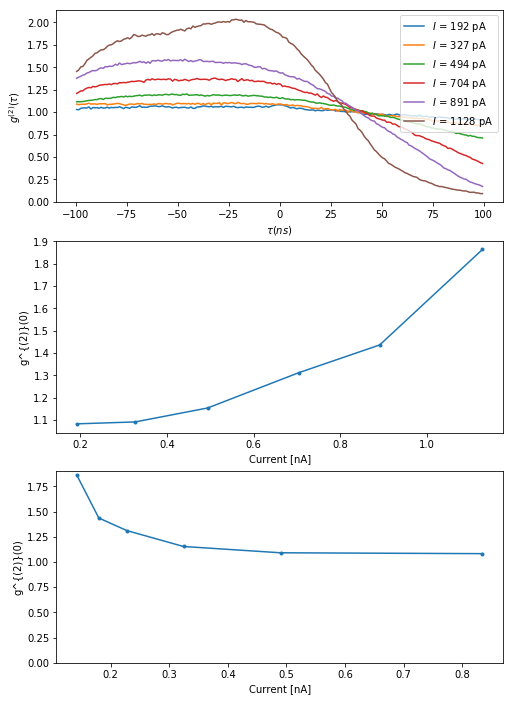

In [9]:
N = int(1e3)      # number of electron arrivals
N_NV = 5          # ratio of NV's to e-'s 
t_r = 10          # NV radiation timescale [ns] 

num = 90
# freq_dist = [1/num] * num                          # 1/f decay 
# freq_dist = [1/(f) for f in range(1,num+1)]
freq_dist = np.linspace(1,.5,90)**1                  # linear decay
freq_dist = list(np.array(freq_dist)/sum(freq_dist)) # normalize 

# lsts = [list(np.logspace(*a,30)) for a in [(1,.5), (0,-.5), (-1.5,-2)]]
# tmscales = lsts[0] + lsts[1] + lsts[2]
# tmscales = np.logspace(1.5,-3.5,num)
tmscales = np.linspace(4,.001,num)

# print('frequency probs and timescales:', list(zip(freq_dist, tmscales)))
    
data = []
currents = [.192, .327, .494, .704, .891, 1.128]    # nA
mean_times = [.1602/I_nA for I_nA in currents]      # ns 
for tm in mean_times:                               # vary I 
    print('mean arrival time [ns]:', tm)
    print('current [nA]: ',1.602*10/tm)
    rt = radiation_times(em_arrrivals(tm, N)[1],
                         N_NV,
                         t_r,
                         freq_dist, #[.25,.25,.25,.25],
                         tmscales) #[2,2,.01,.01])
    d = delays(rt, tau_max)

    hist, bin_edges = np.histogram(d, bins=n_bins)           # Generate the histogram data directly
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.      # Get the centres rather than the edges
    hists = hist/((np.mean(hist[int(3*n_bins/4):]) +
                  np.mean(hist[:int(1*n_bins/4)]))/2)        # Normalize histogram counts
    bins = bin_centers                                       # Plot with [ns] time units
    data.append((bins, hists))

    
f, ax = plt.subplots(3, sharex=False, figsize = (8,12))
for i, d in enumerate(data):
    ax[0].plot(d[0], d[1],)
ax[0].set_xlabel('$\\tau (ns)$')
ax[0].set_ylabel('$g^{(2)}(\\tau)$')
ax[0].legend(['$I$ = ' + str(int(c*1000)) + ' pA' for c in currents])

ax[1].plot(currents, [data[i][1][n_bins//2] for i in range(len(currents))] , '.-')
ax[1].set_xlabel('Current [nA]')
ax[1].set_ylabel('g^{(2)}(0)')


ax[2].plot(mean_times, [data[i][1][n_bins//2] for i in range(len(currents))] , '.-')
ax[2].set_xlabel('Current [nA]')
ax[2].set_ylabel('g^{(2)}(0)')
ax[2].set_ylim(0,)
# ax[1].legend()
plt.show()

In [1]:
N_NV

NameError: name 'N_NV' is not defined

In [146]:
# possible (more exotic) timescale distributions

num=90 
freq_dist = np.linspace(1,.1,90)
freq_dist = list(np.array(freq_dist)/sum(freq_dist))
plt.plot(freq_dist)
# plt.set_title('mode probabilities')
plt.set_xlabel('mode number')
plt.set_ylabel('probability of excitation')
plt.show()


num = 10 
tmscales1 = np.logspace(1,-1.5,num)
tmscales2 = np.linspace(10,.0001,num)

print(list(zip(tmscales1, tmscales2)))
tmscales3 = [5 ** x for x in np.linspace(1,-1.5,num)]
comp_scls = list(np.logspace(1,.5, 5)) + list(np.logspace(0,-.5, 5)) + list(np.logspace(-1,-1.5, 5))
lsts = [list(np.logspace(*a,5)) for a in [(1.5,1), (0,-.5), (-1.5,-2)]]
lsts[0] + lsts[1] + lsts[2]


[(10.0, 10.0), (5.2749970637026182, 8.8888999999999996), (2.7825594022071245, 7.7778), (1.4677992676220695, 6.6667000000000005), (0.774263682681127, 5.5556000000000001), (0.40842386526745217, 4.4444999999999997), (0.21544346900318834, 3.3334000000000001), (0.11364636663857243, 2.2223000000000006), (0.059948425031894091, 1.1112000000000002), (0.031622776601683791, 0.0001)]


[31.622776601683793,
 23.713737056616552,
 17.782794100389228,
 13.33521432163324,
 10.0,
 1.0,
 0.74989420933245587,
 0.56234132519034907,
 0.42169650342858223,
 0.31622776601683794,
 0.031622776601683791,
 0.023713737056616554,
 0.017782794100389229,
 0.013335214321633241,
 0.01]

### A simple model: single variational lifetime

We now explore the effect of the NV radiation rates on the $g^{(2)}(\tau)$ properties.
We do this by varying the NV emission rate and observing its effect on the zero delay signal.
The radiation rate and zero delay signal are found to be approximately inversely proportional. 

In [33]:
data = []
trs = np.logspace(1,-1, 5)                                   # vary emission rates
for t_r in trs:
    at = em_arrrivals(tm, number=N)                          # simulate electron arrival times
    rt = radiation_times(at[1], N_NV, t_r)                   # simulate NV excitations
    print('radiation time : ', t_r)    
    d = delays(rt, tau_max)                                  # simulate NV radiation

    hist, bin_edges = np.histogram(d, bins=n_bins)           # Generate the histogram data directly
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.      # bin centred by delay time
    hists = hist/((np.mean(hist[int(3*n_bins/4):]) +
                  np.mean(hist[:int(1*n_bins/4)]))/2)        # Normalize histogram counts
    bins = bin_centers                                       # Plot with [ns] time units
    data.append((bins, hists))

f, ax = plt.subplots(2, sharex=False, figsize = (10,10))
for i, d in enumerate(data):
    ax[0].plot(d[0], d[1], label='$\\tau_r = ${0}'.format(round(trs[i],1)))  

ax[0].set_xlabel('$\\tau (ns)$')
ax[0].set_ylabel('$g^{(2)}(\\tau)$')
ax[0].legend() 

# # ax[1].plot(trs, [data[i][1][n_bins//2] for i in range(5)] , '.-')
# # ax[1].set_xlabel('radiation timescales')
# # ax[1].set_ylabel('g^{(2)}(0)')
# # ax[1].legend()
plt.show()

for i, d in enumerate(data):
    print(sum(d[1])/len(d[1]))
    

plt.figure(figsize = (10,5))
plt.plot(trs, [2/t+1 for t in trs])
plt.show()

radiation time :  10.0
radiation time :  3.16227766017
radiation time :  1.0


KeyboardInterrupt: 

# A better model with filter parameters

The Frank Cordon principle explains how lattice distortions may couple to the localized defect wavefunctions.

Consider a single phonon oscillating with frequency $\omega_v (\sim 50 meV?)$ which we take from the regular spacing/energy difference between phonon sidebands $\Delta E = \hbar \omega_v. 

This frequency should definitely appear in the phonon spectrum ( https://journals.aps.org/prb/abstract/10.1103/PhysRevB.94.134305, Fig 2).
Now flourescent transitions from the state $|e,0\rangle$ to $|g,k\rangle$ where the state written as $|emitter, phonon\rangle$ and $k \in \mathbb{Z}^+$
Together, the transitions from the individual phonon side bands form the spectrum of phonon mediated emissions (SEE https://arxiv.org/pdf/1302.3288.pdf fig 22). 

To 'filter' the data we use the filter vector $\vec{\alpha}$ with $|\vec{\alpha}|^2 = 1$.
When $\vec{\alpha}=1$ we only consider the ZPL as shown above. In general $\vec{\alpha} = (\alpha_0, \alpha_1, \alpha_2, ...)$ means we that with probability $\alpha_i$, we simulate a transition between the $|e,0\rangle$ to $|g,i\rangle$ with a mofidifed lifetime $\tau_{rad} = \tau_{rad}/c_i$. As infered from the spectral distribution of emissions (and fig 22 referenced above), the lifetimes of the phonon-mediated flouresences are significantly greater that of the sharp ZPL. 

Before examining the results of the simulation it is important to come up with experimentally motivated estimates for the reduced lifetimes (i.e. the $c_i$ factors) and the filter that I should put in for each vibronic mode for each filter type. 


### References:

https://en.wikipedia.org/wiki/Franck%E2%80%93Condon_principle
 
https://en.wikipedia.org/wiki/Zero-phonon_line_and_phonon_sideband
 
https://journals.aps.org/prb/abstract/10.1103/PhysRevB.94.134305   
 
https://arxiv.org/pdf/1302.3288.pdf (NV Review)
 
http://iopscience.iop.org/article/10.1088/0022-3719/7/20/019/pdf  (Diamond phonon bands)
 
https://www.nature.com/articles/ncomms14000.pdf (Stimulated emission from nitrogen-vacancy centres in diamond)

http://onlinelibrary.wiley.com/doi/10.1002/pssa.200671403/abstract  (Single defect centres in diamond: A review)

filter: [1, 0, 0, 0]
filter: [0.7, 0.2, 0.1, 0]
filter: [0.2, 0.4, 0.3, 0.1]
filter: [0, 0.2, 0.5, 0.3]
filter: [0, 0, 0.6, 0.4]
filter: [0, 0, 0, 1]


/Users/DumiMac/Library/Python/3.5/lib/python/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


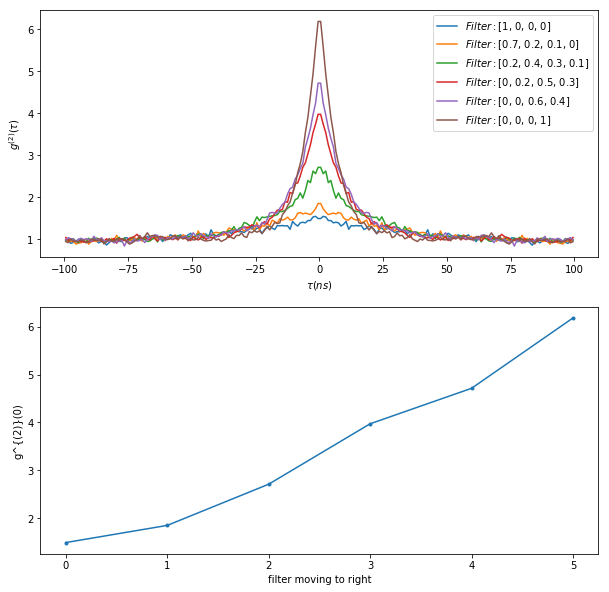

In [40]:
# Physical scales #
tm = 80           # electron mean arrival time [ns] -----    # corresponds to ~ .5 nA 
N = int(2e3)      # number of electron events
N_NV = 5          # ratio of NV's to e-'s 
t_r = 50          # NV radiation timescale [ns] 


alphas = [[1,0,0,0], [.7,.2,.1,0], [.2,.4,.3,.1], [0,.2,.5,.3], [0,0,.6,.4], [0,0,0,1]]
relax_ratios = [1,.5,.25,.125]                               # c_i's defined in above discussion
data = []
for a in alphas:
    print('filter:', a)
    at = em_arrrivals(tm, number=N)[1]             # arrival times
    rt = radiation_times(at, N_NV, t_r,a, relax_ratios)
    d = delays(rt, tau_max)

    # look through delays at different currents 

    hist, bin_edges = np.histogram(d, bins=n_bins)           # Generate the histogram data directly
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.      # Get the centres rather than the edges
    hists = hist/((np.mean(hist[int(3*n_bins/4):]) +
                  np.mean(hist[:int(1*n_bins/4)]))/2)        # Normalize histogram counts
    bins = bin_centers                                       # Plot with [ns] time units
    data.append((bins, hists))

    
f, ax = plt.subplots(2, sharex=False, figsize = (10,10))
for i, d in enumerate(data):
    ax[0].plot(d[0], d[1],)
ax[0].set_xlabel('$\\tau (ns)$')
ax[0].set_ylabel('$g^{(2)}(\\tau)$')
ax[0].legend(['$Filter : $' + str(a) for a in alphas])

ax[1].plot([data[i][1][n_bins//2] for i in range(len(alphas))] , '.-')
ax[1].set_xlabel('filter moving to right')
ax[1].set_ylabel('g^{(2)}(0)')
ax[1].legend()
plt.show()
